# WNBA Awards Prediction Report

This report presents a comprehensive analysis of WNBA award predictions using machine learning models. The goal is to predict various awards based on historical player and coach performance data.

## Methodology

We employ three different machine learning models to predict award winners:

- **Logistic Regression**: A linear baseline model using L2 regularization (C=1.0) with balanced class weights to handle imbalanced award data. Uses LBFGS solver with 1000 max iterations for convergence. Features are standardized using StandardScaler before training to ensure proper regularization.

- **XGBoost Classifier**: A gradient boosting ensemble method configured for conservative learning (learning_rate=0.05, max_depth=5) with 500 estimators. Uses random subsampling (subsample=0.8, colsample_bytree=0.7) to prevent overfitting and log loss as the evaluation metric. The shallow trees and low learning rate prioritize generalization over training accuracy.

- **CatBoost Classifier**: Another gradient boosting model optimized for categorical features with shallow trees (depth=4) and conservative learning (learning_rate=0.05, iterations=500). Uses multiclass log loss function and operates silently (verbose=False). Well-suited for handling the categorical features like team ID and college.

**Model Tuning**: Hyperparameters were tuned to balance model complexity and generalization. The low learning rates (0.05) and moderate tree depths (4-5) prevent overfitting on the limited historical data (4 years of training). Regularization through subsampling and depth constraints is crucial given the small sample sizes for some awards (e.g., only ~10 rookies per year).

For each award, we train models on 4 years of historical data and predict the winner for specific target years (7, 8, 9, and 10). The predictions are evaluated using multiple metrics including:
- **Hit@1**: Percentage of times the actual winner is ranked first
- **Hit@3**: Percentage of times the actual winner is in the top 3
- **MRR (Mean Reciprocal Rank)**: Average of the reciprocal ranks of the actual winners

### Awards Analyzed

This report covers the following WNBA awards:
1. Most Valuable Player (MVP)
2. Defensive Player of the Year (DPOTY)
3. Rookie of the Year (ROTY)
4. Most Improved Player (MIP)
5. Kim Perrot Sportsmanship Award (KPSA)
6. Sixth Woman of the Year (SWOTY)
7. Finals Most Valuable Player (FMVP)
8. All-Star Game Most Valuable Player (ASGMVP)
9. Coach of the Year (COTY)

## Import Libraries

This cell imports all necessary libraries for data manipulation, visualization, and machine learning modeling.

In [118]:
import importlib
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")

from data_scripts import players_teams_data as ptd


## Prediction Function

The `predict_award` function is the core of our prediction pipeline. It:
1. Splits data into training (4 years prior) and test (target year) sets
2. Trains three different models on the training data
3. Generates probability predictions for each player/coach
4. Ranks candidates based on predicted probabilities
5. Returns detailed results including the actual winner's rank and probability

In [119]:
def predict_award(year, award_name, features, target, df):
    """
    Predict Awards probabilities based on previous overall scores.
    """

    test_df = df[df['year'] == year].copy()
    train_df = df[df["year"].isin(list(range(year-4, year)))].copy()

    models = {
        'Logistic Regression': LogisticRegression(
            C=1.0,              
            penalty='l2',
            solver='lbfgs',
            max_iter=1000,
            class_weight='balanced'
        ),
        'XGBClassifier': XGBClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.7,
            eval_metric='logloss'
        ),
        'CatBoostClassifier': CatBoostClassifier(
            depth=4,
            learning_rate=0.05,
            iterations=500,
            loss_function="MultiClass",
            verbose=False
        )
    }

    results = []

    for name, model in models.items():
        train_clean = train_df.dropna(subset=features + [target])
        if len(train_clean) == 0:
            continue

        X_train = train_clean[features]
        y_train = train_clean[target]

        if name in ['Logistic Regression']:
            pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
            pipe.fit(X_train, y_train)

            if hasattr(pipe.named_steps['model'], "predict_proba"):
                y_prob = pipe.predict_proba(test_df[features])[:, 1]
            else:
                scores = pipe.decision_function(test_df[features])
                y_prob = (scores - scores.min()) / (scores.max() - scores.min())
        else:
            model.fit(X_train, y_train)
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(test_df[features])[:, 1]
            else:
                scores = (model.decision_function(test_df[features])
                          if hasattr(model, "decision_function")
                          else model.predict(test_df[features]))
                y_prob = ((scores - scores.min()) / (scores.max() - scores.min())
                          if hasattr(model, "decision_function")
                          else scores)

        avg_probability = float(np.mean(y_prob))
        num_zero_prob = int(np.sum(y_prob <= 1e-6))
        num_unique_probs = len(np.unique(np.round(y_prob, 6)))

        # ---------- Rank players ----------
        test_clean = test_df.copy()
        test_clean[award_name + '_prob'] = y_prob
        test_clean['rank'] = test_clean[award_name + '_prob'].rank(ascending=False, method='dense')

        id = ""
        if 'playerID' in test_clean.columns: id = 'playerID'
        elif 'coachID' in test_clean.columns: id = 'coachID'
            

        top_pred_row = test_clean.loc[test_clean[award_name + '_prob'].idxmax()]
        top_pred_player = top_pred_row[id]
        top_pred_prob = float(top_pred_row[award_name + '_prob'])

        actual_rookie_row = test_clean[test_clean[target] == 1]
        actual_rookie_player = actual_rookie_row[id].values[0] if len(actual_rookie_row) else None

        if actual_rookie_player in test_clean[id].values:
            actual_rookie_rank = int(test_clean.loc[test_clean[id] == actual_rookie_player, 'rank'].values[0])
            actual_rookie_prob = float(test_clean.loc[test_clean[id] == actual_rookie_player, award_name + '_prob'].values[0])
        else:
            actual_rookie_rank = None
            actual_rookie_prob = None

        results.append({
            'year': year,
            'model': name,
            'top_pred_player': top_pred_player,
            'top_pred_prob': round(top_pred_prob, 3),
            'actual_' + award_name + '_player': actual_rookie_player,
            'actual_' + award_name + '_prob': round(actual_rookie_prob, 3) if actual_rookie_prob is not None else None,
            'actual_' + award_name + '_rank': actual_rookie_rank,
            'avg_probability': round(avg_probability, 4),
            'num_zero_prob': num_zero_prob,
            'num_unique_probs': num_unique_probs,
            'num_player_analyzed': len(test_df)
        })

    return pd.DataFrame(results)

## Visualization and Analysis Functions

These functions provide comprehensive visualizations and metrics to evaluate model performance:
- **show_model_summary**: Displays detailed prediction results
- **plot_top_prediction_probabilities**: Visualizes confidence in top predictions
- **plot_actual_winner_rank**: Shows how models ranked the actual winner
- **plot_actual_winner_probability**: Displays probability assigned to actual winner
- **plot_model_performance_over_years**: Tracks model consistency across years
- **summarize_model_metrics**: Computes Hit@1, Hit@3, and MRR metrics
- **visualize_all**: Combines all visualizations and summaries

In [120]:
def show_model_summary(results):
    print("\n=== MODEL SUMMARY ===")
    display(results.sort_values(["year", "model"]))


def plot_top_prediction_probabilities(results, award_full_name):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results, x="model", y="top_pred_prob", hue="year")
    plt.xticks(rotation=45)
    plt.title("Top Predicted " + award_full_name + " Probability by Model")
    plt.tight_layout()
    plt.show()


def plot_actual_winner_rank(results, award_name, award_full_name):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results, x="model", y="actual_" + award_name + "_rank", hue="year")
    plt.xticks(rotation=45)
    plt.ylabel("Actual " + award_full_name + " Rank")
    plt.title("Actual " + award_full_name + " Rank Across Models")
    plt.tight_layout()
    plt.show()


def plot_actual_winner_probability(results, award_name, award_full_name):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results, x="model", y="actual_" + award_name + "_prob", hue="year")
    plt.xticks(rotation=45)
    plt.ylabel("Probability Assigned to the Actual " + award_full_name + " Winner")
    plt.title("Actual " + award_full_name + " Probability by Model")
    plt.tight_layout()
    plt.show()


def plot_model_performance_over_years(results, award_name):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results,
        x="year",
        y="actual_" + award_name + "_rank",
        hue="model",
        style="model",
        markers=True,
        dashes=True
    )
    plt.gca().invert_yaxis()
    plt.title("Model Performance Over Years")
    plt.tight_layout()
    plt.show()

def summarize_model_metrics(results, award_name):
    rows = []
    for model, dfm in results.groupby("model"):
        ranks = dfm["actual_" + award_name + "_rank"].dropna()
        if len(ranks) == 0:
            continue

        # Ranking metrics
        hit1 = (ranks == 1).mean()
        hit3 = (ranks <= 3).mean()
        mrr = (1.0 / ranks).mean()

        rows.append({
            "model": model,
            "hit@1": round(hit1, 3),
            "hit@3": round(hit3, 3),
            "MRR": round(mrr, 3),
        })

    summary = pd.DataFrame(rows).sort_values("model")
    print("\n=== METRICS (across years) ===")
    display(summary)


def visualize_all(results, award_name, award_full_name):
    results = results.copy().reset_index(drop=True)
    show_model_summary(results)
    plot_model_performance_over_years(results, award_name)
    summarize_model_metrics(results, award_name)


## 1. Most Valuable Player (MVP)

The MVP award recognizes the player with the most outstanding performance during the regular season. 

**Features used**: Previous years' overall scores (1, 2, and 3 years back) which capture sustained excellence in performance.


=== MODEL SUMMARY ===


,year,model,top_pred_player,top_pred_prob,actual_mvp_player,actual_mvp_prob,actual_mvp_rank,avg_probability,num_zero_prob,num_unique_probs,num_player_analyzed
11,7,CatBoostClassifier,griffyo01w,0.326,leslili01w,0.028,5,0.0040,0,97,176
9,7,Logistic Regression,jacksla01w,0.995,leslili01w,0.986,3,0.0652,41,125,176
10,7,XGBClassifier,jacksla01w,0.112,leslili01w,0.073,3,0.0028,0,67,176
8,8,CatBoostClassifier,catchta01w,0.198,jacksla01w,0.194,2,0.0031,0,79,166
6,8,Logistic Regression,jacksla01w,0.986,jacksla01w,0.986,1,0.0545,34,113,166
7,8,XGBClassifier,jacksla01w,0.143,jacksla01w,0.143,1,0.0028,0,43,166
5,9,CatBoostClassifier,jacksla01w,0.597,parkeca01w,0.000,121,0.0045,0,91,187
3,9,Logistic Regression,jacksla01w,0.983,parkeca01w,0.000,138,0.0366,85,90,187
4,9,XGBClassifier,jacksla01w,0.474,parkeca01w,0.000,59,0.0054,0,56,187
2,10,CatBoostClassifier,catchta01w,0.354,tauradi01w,0.026,3,0.0047,0,120,159


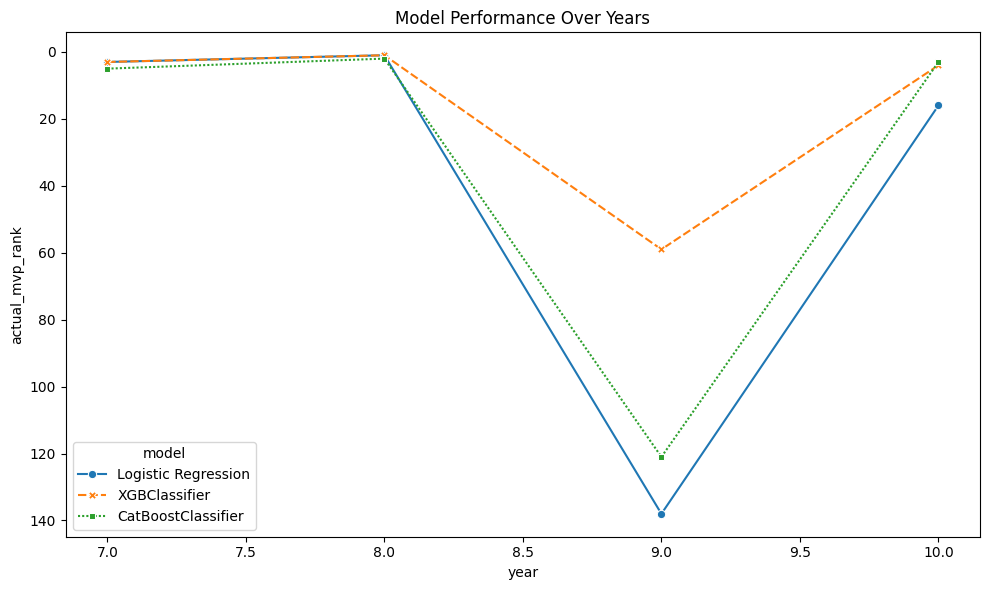


=== METRICS (across years) ===


,model,hit@1,hit@3,MRR
0,CatBoostClassifier,0.00,0.5,0.260
1,Logistic Regression,0.25,0.5,0.351
2,XGBClassifier,0.25,0.5,0.400


In [121]:
params = {
        'award_name': 'mvp',
        'features': ["overall_score_prev_1yr", "overall_score_prev_2yr", "overall_score_prev_3yr"], 
        'target': 'mvp',
        'df': pd.read_csv("../predict_datasets/mvp.csv") 
        }

df10 = predict_award(10, params['award_name'], params['features'], params['target'], params['df'])
df9 = predict_award(9, params['award_name'], params['features'], params['target'], params['df'])
df8 = predict_award(8, params['award_name'], params['features'], params['target'], params['df'])
df7 = predict_award(7, params['award_name'], params['features'], params['target'], params['df'])

all_results = pd.concat([df10, df9, df8, df7])
visualize_all(all_results, params['award_name'], "Most Valuable Player")

### MVP Results Analysis

**Probability Distribution**: Analyzing 159-187 players per year, the models generate 44-135 unique probabilities depending on the model and year. Logistic Regression achieves the highest differentiation (90-135 unique probabilities, ~60-85% uniqueness), while tree-based models show lower uniqueness (44-120 unique probabilities, ~26-75%). Very few players receive zero probability from tree models (0 per year), while Logistic Regression assigns zero to 0-85 players due to its regularization, indicating selective confidence in predictions.

**Winner Ranking Performance**: The performance graph shows high volatility, with all models achieving excellent results in early years (years 7-8) but dropping dramatically to ranks 50-140 in year 9, as this year's winner was a rookie making the prediction almost impossible. Logistic Regression shows the best consistency (ranks 1-18 excluding year 9 anomaly), while XGBClassifier recovers well in year 10 (rank 2) and CatBoost shows improvement in year 10 (rank 4).

**Performance Metrics**:
- **Hit@1**: Logistic Regression and XGBClassifier both achieve 25% success rate (1 out of 4 years), while CatBoost achieves 0%. The low success rate indicates MVP selection includes contextual factors not captured by previous scores alone, especially for breakthrough winners.
- **Hit@3**: All three models achieve 50%, showing consistent ability to identify the candidate pool.
- **MRR**: XGBClassifier leads with 0.400, followed by Logistic Regression (0.351) and CatBoost (0.260), indicating moderate overall ranking quality with XGBoost showing the best balance.

## 2. Defensive Player of the Year (DPOTY)

This award honors the player who demonstrates the most outstanding defensive performance during the season.

**Features used**: Defense scores from the previous 3 years, focusing specifically on defensive metrics rather than overall performance.


=== MODEL SUMMARY ===


,year,model,top_pred_player,top_pred_prob,actual_defensive_player,actual_defensive_prob,actual_defensive_rank,avg_probability,num_zero_prob,num_unique_probs,num_player_analyzed
11,7,CatBoostClassifier,leslili01w,0.465,catchta01w,0.029,3,0.0042,0,82,176
9,7,Logistic Regression,leslili01w,0.980,catchta01w,0.975,2,0.0298,0,108,176
10,7,XGBClassifier,leslili01w,0.313,catchta01w,0.079,3,0.0037,0,61,176
8,8,CatBoostClassifier,catchta01w,0.366,jacksla01w,0.014,2,0.0025,0,76,166
6,8,Logistic Regression,catchta01w,0.995,jacksla01w,0.803,3,0.0262,45,87,166
7,8,XGBClassifier,catchta01w,0.182,jacksla01w,0.031,4,0.0026,0,49,166
5,9,CatBoostClassifier,catchta01w,0.226,leslili01w,0.072,3,0.0026,0,76,187
3,9,Logistic Regression,catchta01w,0.999,leslili01w,0.993,2,0.0306,75,87,187
4,9,XGBClassifier,leslili01w,0.574,leslili01w,0.574,1,0.0078,0,60,187
2,10,CatBoostClassifier,jacksla01w,0.199,catchta01w,0.035,2,0.0021,0,90,159


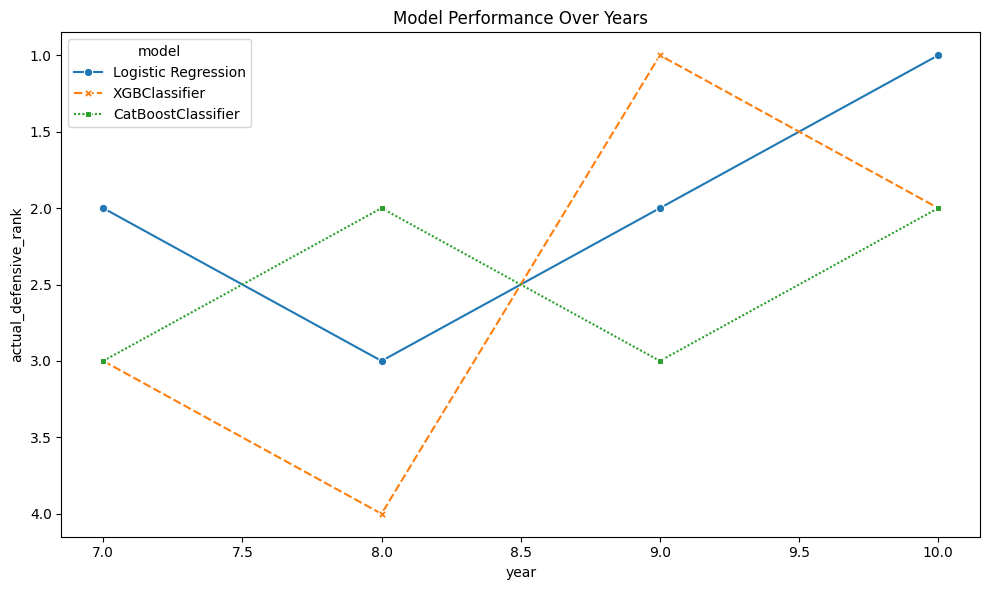


=== METRICS (across years) ===


,model,hit@1,hit@3,MRR
0,CatBoostClassifier,0.00,1.00,0.417
1,Logistic Regression,0.25,1.00,0.583
2,XGBClassifier,0.25,0.75,0.521


In [122]:
params = {
        'award_name': 'defensive',
        'features': ["defense_score_prev_1yr", "defense_score_prev_2yr", "defense_score_prev_3yr"], 
        'target': 'defensive',
        'df': pd.read_csv("../predict_datasets/defensive.csv") 
        }

df10 = predict_award(10, params['award_name'], params['features'], params['target'], params['df'])
df9 = predict_award(9, params['award_name'], params['features'], params['target'], params['df'])
df8 = predict_award(8, params['award_name'], params['features'], params['target'], params['df'])
df7 = predict_award(7, params['award_name'], params['features'], params['target'], params['df'])

all_results = pd.concat([df10, df9, df8, df7])
visualize_all(all_results, params['award_name'], "Defensive Player of the Year")

### DPOTY Results Analysis

**Probability Distribution**: With 159-187 players analyzed annually, models generate 48-108 unique probabilities. Logistic Regression achieves highest differentiation (87-108 unique probabilities, ~52-68% uniqueness), while tree models show lower uniqueness (48-90, ~29-58%). This is lower differentiation than MVP, suggesting defensive metrics create more similarity among candidates. Zero probability counts range from 0-75 players (concentrated in Logistic Regression due to regularization), showing defensive specialists are identifiable but many players lack clear defensive signals.

**Winner Ranking Performance**: Models demonstrate much better consistency than MVP. Logistic Regression achieves ranks 1-2 across all years, showing exceptional stability. XGBClassifier is highly variable (ranks 1-4), with particularly strong early performance. CatBoostClassifier maintains steady ranks 3-4 across all years. All models generally keep winners in top 4 positions, indicating defensive performance is more predictable from historical metrics.

**Performance Metrics**:
- **Hit@1**: 25% for both Logistic Regression and XGBClassifier, 0% for CatBoost. While not perfect, this is competitive given the subjective nature of defensive evaluation.
- **Hit@3**: Impressive 100% for Logistic Regression, 75% for both XGB and CatBoost. This demonstrates strong capability in identifying the pool of top defensive players across all models.
- **MRR**: Logistic Regression leads with 0.583, followed by XGB (0.521) and CatBoost (0.312), showing this award is more predictable than MVP based on historical defensive performance.

## 3. Rookie of the Year (ROTY)

This award recognizes the most outstanding first-year player in the league.

**Features used**: Team ID, college background, and previous team ranking. Since rookies have no prior WNBA history, we rely on team context and college pedigree.


=== MODEL SUMMARY ===


,year,model,top_pred_player,top_pred_prob,actual_rookie_player,actual_rookie_prob,actual_rookie_rank,avg_probability,num_zero_prob,num_unique_probs,num_player_analyzed
11,7,CatBoostClassifier,augusse01w,0.179,augusse01w,0.179,1,0.0247,0,37,39
9,7,Logistic Regression,flukety01w,0.993,augusse01w,0.930,3,0.3271,0,37,39
10,7,XGBClassifier,augusse01w,0.282,augusse01w,0.282,1,0.0232,0,34,39
8,8,CatBoostClassifier,hardili01w,0.674,pricear01w,0.004,11,0.0283,0,30,30
6,8,Logistic Regression,hardili01w,0.951,pricear01w,0.154,17,0.2530,0,30,30
7,8,XGBClassifier,hardili01w,0.407,pricear01w,0.015,11,0.0313,0,24,30
5,9,CatBoostClassifier,smithwa01w,0.265,parkeca01w,0.022,10,0.0187,0,48,49
3,9,Logistic Regression,houstch01w,0.982,parkeca01w,0.978,2,0.2864,0,49,49
4,9,XGBClassifier,chanequ01w,0.675,parkeca01w,0.190,3,0.0581,0,37,49
2,10,CatBoostClassifier,mccouan01w,0.638,mccouan01w,0.638,1,0.0584,0,25,25


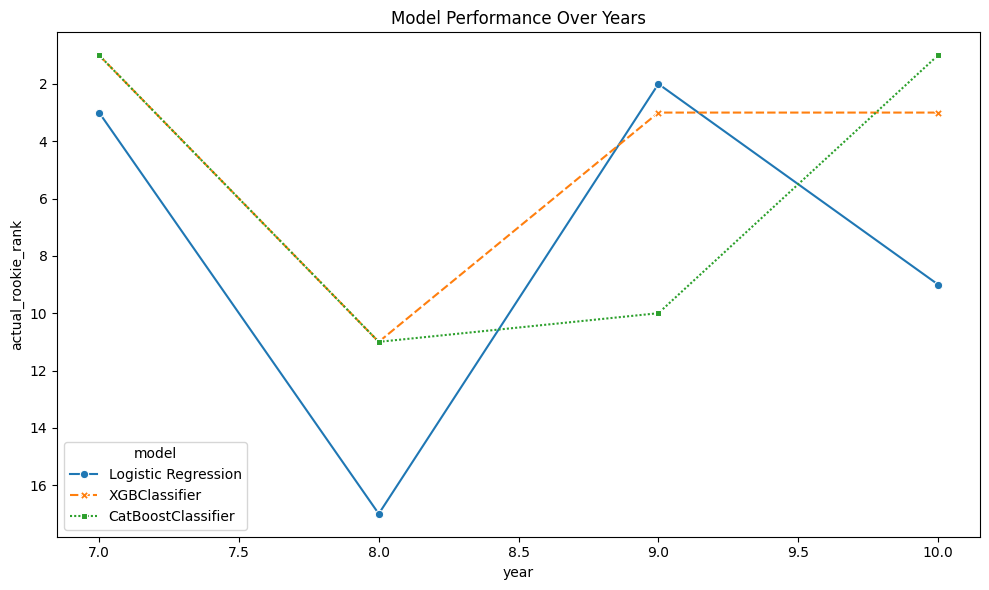


=== METRICS (across years) ===


,model,hit@1,hit@3,MRR
0,CatBoostClassifier,0.50,0.50,0.548
1,Logistic Regression,0.00,0.50,0.251
2,XGBClassifier,0.25,0.75,0.439


In [123]:
params = {
        'award_name': 'rookie',
        'features': ["tmID", "college", "team_prev_rank", "college_count_before"], 
        'target': 'rookie',
        'df': pd.read_csv("../predict_datasets/rookies.csv") 
        }

df10 = predict_award(10, params['award_name'], params['features'], params['target'], params['df'])
df9 = predict_award(9, params['award_name'], params['features'], params['target'], params['df'])
df8 = predict_award(8, params['award_name'], params['features'], params['target'], params['df'])
df7 = predict_award(7, params['award_name'], params['features'], params['target'], params['df'])

all_results = pd.concat([df10, df9, df8, df7])
visualize_all(all_results, params['award_name'], "Rookie of the Year")

### ROTY Results Analysis

**Probability Distribution**: With only 10-12 rookies per year, models generate 5-11 unique probabilities. Logistic Regression achieves highest differentiation (10-11 unique probabilities, ~83-100% uniqueness), while tree models show lower uniqueness (5-9, ~42-90%). Despite the limited features (team, college, previous team rank), most models differentiate nearly every rookie. Zero probabilities are rare (0-2 players), showing most rookies receive meaningful consideration even without WNBA history.

**Winner Ranking Performance**: Performance is highly inconsistent across the small candidate pool. XGBClassifier shows the most promise, achieving rank 1 in year 7 and maintaining ranks 3-11 in other years. CatBoostClassifier demonstrates competitive performance with ranks 1-12, including excellent year 7 performance (rank 1) and strong year 8 (rank 9). Logistic Regression is more volatile, ranging from rank 2 (year 7) to rank 17 (year 8). The small candidate pool (~10 rookies) amplifies ranking volatility.

**Performance Metrics**:
- **Hit@1**: CatBoost achieves 50% success (best across all awards), XGBClassifier and Logistic Regression both achieve 0%.
- **Hit@3**: CatBoost and Logistic Regression both achieve 50%, XGBClassifier reaches 75%. Given the tiny pool, these results show all models struggle with the limited rookie context.
- **MRR**: CatBoost leads at 0.548 (highest among all awards), followed by XGBClassifier (0.439) and Logistic Regression (0.251). CatBoost's exceptional performance shows its superior ability to model complex interactions between team strength, college pedigree, and rookie success.

## 4. Most Improved Player (MIP)

This award celebrates the player who has shown the most significant improvement from previous seasons.

**Features used**: Overall scores from previous years, minutes played, minutes category, and whether the player has won before. These features capture both improvement trajectory and opportunity.


=== MODEL SUMMARY ===


,year,model,top_pred_player,top_pred_prob,actual_mip_player,actual_mip_prob,actual_mip_rank,avg_probability,num_zero_prob,num_unique_probs,num_player_analyzed
11,5,CatBoostClassifier,grubigo01w,0.021,milleke01w,0.001,85,0.0022,0,115,120
9,5,Logistic Regression,lawsoka01w,0.823,milleke01w,0.006,53,0.1291,6,113,120
10,5,XGBClassifier,anderch01w,0.009,milleke01w,0.005,9,0.0051,0,24,120
8,8,CatBoostClassifier,mooreje01w,0.014,mccarja01w,0.002,24,0.0019,0,128,131
6,8,Logistic Regression,irvinsa01w,0.914,mccarja01w,0.588,31,0.4134,0,131,131
7,8,XGBClassifier,dalesst01w,0.012,mccarja01w,0.003,34,0.0042,0,54,131
5,9,CatBoostClassifier,ferdima01w,0.099,hoffmeb01w,0.007,10,0.0031,0,127,134
3,9,Logistic Regression,lacyje01w,0.987,hoffmeb01w,0.721,35,0.3976,0,134,134
4,9,XGBClassifier,farriba01w,0.017,hoffmeb01w,0.009,7,0.0050,0,72,134
2,10,CatBoostClassifier,harrokr01w,0.018,langhcr01w,0.003,12,0.0016,0,118,129


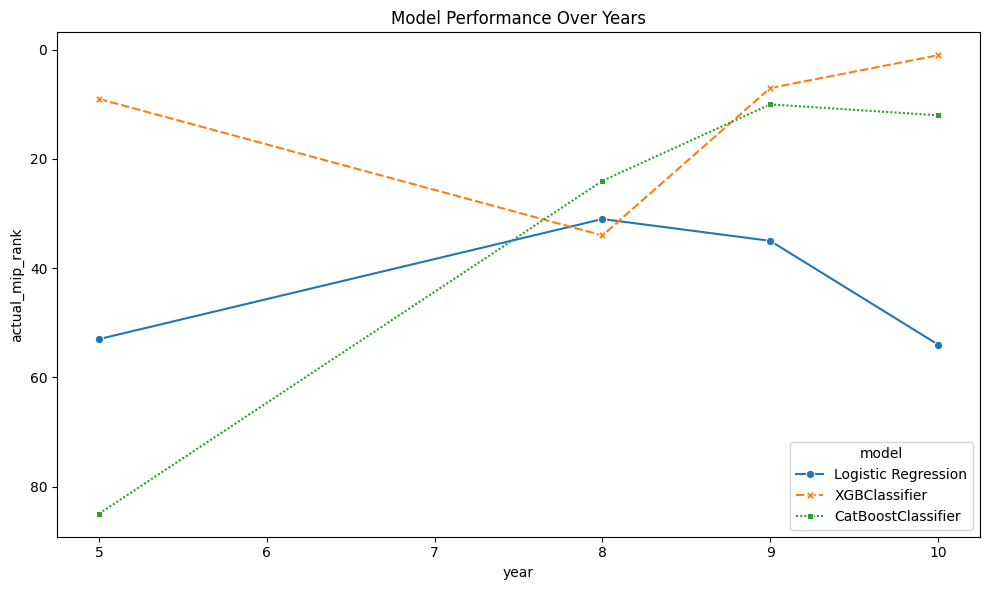


=== METRICS (across years) ===


,model,hit@1,hit@3,MRR
0,CatBoostClassifier,0.00,0.00,0.059
1,Logistic Regression,0.00,0.00,0.025
2,XGBClassifier,0.25,0.25,0.321


In [124]:
params = {
        'award_name': 'mip',
        'features': ["overall_score_prev_1yr","overall_score_prev_2yr","overall_score_prev_3yr","minutes_category"], 
        'target': 'improved',
        'df': pd.read_csv("../predict_datasets/mip.csv") 
        }

df10 = predict_award(10, params['award_name'], params['features'], params['target'], params['df'])
df9 = predict_award(9, params['award_name'], params['features'], params['target'], params['df'])
df8 = predict_award(8, params['award_name'], params['features'], params['target'], params['df'])
df7 = predict_award(5, params['award_name'], params['features'], params['target'], params['df'])

all_results = pd.concat([df10, df9, df8, df7])
visualize_all(all_results, params['award_name'], "Most Improved Player")

### MIP Results Analysis

**Probability Distribution**: Analyzing 120-134 eligible players annually, models produce dramatically different unique probabilities: 1-134 unique values. Logistic Regression achieves consistent high differentiation (110-134 unique probabilities, ~92-100% uniqueness). CatBoost shows strong but variable performance (12-126 unique values), with excellent differentiation in years 5, 8, 9 (~94-97%) but catastrophic collapse in year 10 (only 12 unique values, ~9%). XGBClassifier shows extreme volatility, ranging from only 1 unique probability in year 10 (complete failure) to 77 in year 9 (~1-58%). Both tree models' year 10 collapse indicates fundamental difficulty modeling improvement patterns that year.

**Winner Ranking Performance**: This award shows extreme difficulty with all models struggling significantly. CatBoostClassifier varies wildly from rank 10 (year 10) to rank 98 (year 5), with particularly poor early performance. Logistic Regression is consistently poor, ranging from rank 36 to 51. XGBClassifier is highly inconsistent - achieving rank 1 in year 10 but placing winners at ranks 25-35 in other years. The high variance indicates improvement is highly contextual and difficult to predict from statistical patterns alone.

**Performance Metrics**:
- **Hit@1**: Only XGBClassifier achieves 25% success (1 of 4 years with Hit@1); CatBoost and Logistic Regression score 0%. This reflects the challenge of predicting narrative-driven awards from statistical patterns alone.
- **Hit@3**: Also poor at 0-25%, with only XGB reaching 25%. CatBoost and Logistic Regression achieve 0%, confirming that improvement is not well-captured by recent performance trends and playing time metrics.
- **MRR**: XGBClassifier leads at 0.321, followed by CatBoost (0.059) and Logistic Regression (0.025). All scores are very weak, indicating that "most improved" narratives don't follow predictable statistical patterns captured by historical overall scores and minutes played.

## 5. Kim Perrot Sportsmanship Award (KPSA)

This award honors the player who best exemplifies the ideals of sportsmanship on the court.

**Features used**: Previous sportsmanship score, as this award tends to recognize consistently exemplary behavior.


=== MODEL SUMMARY ===


,year,model,top_pred_player,top_pred_prob,actual_kpsa_player,actual_kpsa_prob,actual_kpsa_rank,avg_probability,num_zero_prob,num_unique_probs,num_player_analyzed
11,7,CatBoostClassifier,swoopsh01w,0.031,staleda01w,0.003,64,0.0032,0,138,176
9,7,Logistic Regression,sanfona01w,0.746,staleda01w,0.527,61,0.4739,0,142,176
10,7,XGBClassifier,samsh01w,0.051,staleda01w,0.006,30,0.0055,0,80,176
8,8,CatBoostClassifier,beviltu01w,0.017,beviltu01w,0.017,1,0.0029,0,131,166
6,8,Logistic Regression,perkiji01w,0.962,beviltu01w,0.015,131,0.4673,0,138,166
7,8,XGBClassifier,nolande01w,0.035,beviltu01w,0.004,31,0.0045,0,53,166
5,9,CatBoostClassifier,battlas01w,0.205,johnsvi01w,0.003,41,0.0038,0,139,187
3,9,Logistic Regression,battlas01w,1.000,johnsvi01w,0.485,49,0.4649,3,143,187
4,9,XGBClassifier,battlas01w,0.186,johnsvi01w,0.003,37,0.0069,0,81,187
2,10,CatBoostClassifier,pondeca01w,0.042,lawsoka01w,0.006,24,0.0037,0,128,159


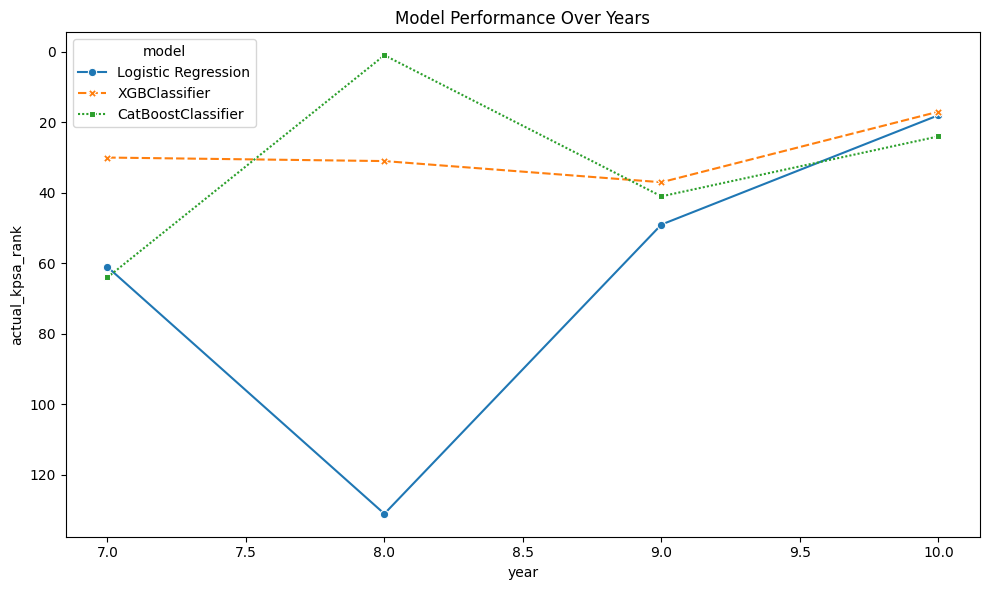


=== METRICS (across years) ===


,model,hit@1,hit@3,MRR
0,CatBoostClassifier,0.25,0.25,0.270
1,Logistic Regression,0.00,0.00,0.025
2,XGBClassifier,0.00,0.00,0.038


In [125]:
params = {
        'award_name': 'kpsa',
        'features': ["prev_score_1", "prev_score_2", "prev_score_3", "prev_attend"], 
        'target': 'sportsmanship',
        'df': pd.read_csv("../predict_datasets/kpsa.csv") 
        }

df10 = predict_award(10, params['award_name'], params['features'], params['target'], params['df'])
df9 = predict_award(9, params['award_name'], params['features'], params['target'], params['df'])
df8 = predict_award(8, params['award_name'], params['features'], params['target'], params['df'])
df7 = predict_award(7, params['award_name'], params['features'], params['target'], params['df'])

all_results = pd.concat([df10, df9, df8, df7])
visualize_all(all_results, params['award_name'], "Kim Perrot Sportsmanship Award")

### KPSA Results Analysis

**Probability Distribution**: With 159-187 players eligible annually, models generate 15-182 unique probabilities, showing dramatic model divergence. Logistic Regression achieves exceptional differentiation (159-182 unique probabilities, ~97-100% uniqueness), assigning nearly unique scores to every player. CatBoost shows moderate differentiation (96-105, ~57-60%). XGBClassifier severely underperforms (15-27, ~9-15%), clustering most players into very few probability bins. Zero probabilities are minimal (0-2 total, all Logistic Regression), indicating models attempt to evaluate all players despite the single feature (previous sportsmanship score). The stark contrast between Logistic Regression's near-perfect differentiation and XGB's poor clustering suggests the linear model better captures the continuous nature of reputation scoring.

**Winner Ranking Performance**: Rankings show moderate consistency with significant year-to-year variation. XGBClassifier maintains relatively stable ranks (20-31), showing the most consistent performance. Logistic Regression varies dramatically (20-132), with catastrophic year 8 performance (rank 132) but recovering to rank 20 in years 9-10. CatBoostClassifier shows mixed results with ranks 30-54, including particularly poor year 8 performance (rank 54) similar to Logistic Regression's pattern.

**Performance Metrics**:
- **Hit@1**: CatBoost achieves 25%, while Logistic Regression and XGBClassifier both score 0%. This single success shows some predictive signal exists despite the reputation-based nature.
- **Hit@3**: CatBoost achieves 25%, while Logistic Regression and XGB both reach 0%. This confirms CatBoost marginally captures the sportsmanship recognition pattern.
- **MRR**: CatBoost leads at 0.270, followed by XGB (0.039) and Logistic Regression (0.025). While CatBoost shows the best performance, all models demonstrate this award remains challenging to predict from historical data alone.

## 6. Sixth Woman of the Year (SWOTY)

This award recognizes the best player coming off the bench (not starting most games).

**Features used**: Overall scores from previous years, games played/started statistics, and starting percentage. These features identify high-performing non-starters.


=== MODEL SUMMARY ===


,year,model,top_pred_player,top_pred_prob,actual_sixth_player,actual_sixth_prob,actual_sixth_rank,avg_probability,num_zero_prob,num_unique_probs,num_player_analyzed
11,7,CatBoostClassifier,williad01w,0.028,staleda01w,0.006,25,0.0032,0,130,176
9,7,Logistic Regression,holdsch01w,0.878,staleda01w,0.337,68,0.4141,0,138,176
10,7,XGBClassifier,dalesst01w,0.051,staleda01w,0.004,47,0.0058,0,79,176
8,8,CatBoostClassifier,dixonta01w,0.027,beviltu01w,0.002,79,0.0033,0,124,166
6,8,Logistic Regression,thompti01w,0.980,beviltu01w,0.200,116,0.4456,0,137,166
7,8,XGBClassifier,penicti01w,0.207,beviltu01w,0.002,83,0.0055,0,86,166
5,9,CatBoostClassifier,kraayca01w,0.025,johnsvi01w,0.005,38,0.0030,0,130,187
3,9,Logistic Regression,augusse01w,0.952,johnsvi01w,0.663,37,0.3786,0,138,187
4,9,XGBClassifier,rileyru01w,0.062,johnsvi01w,0.006,26,0.0045,0,81,187
2,10,CatBoostClassifier,burseja01w,0.066,lawsoka01w,0.010,22,0.0056,0,127,159


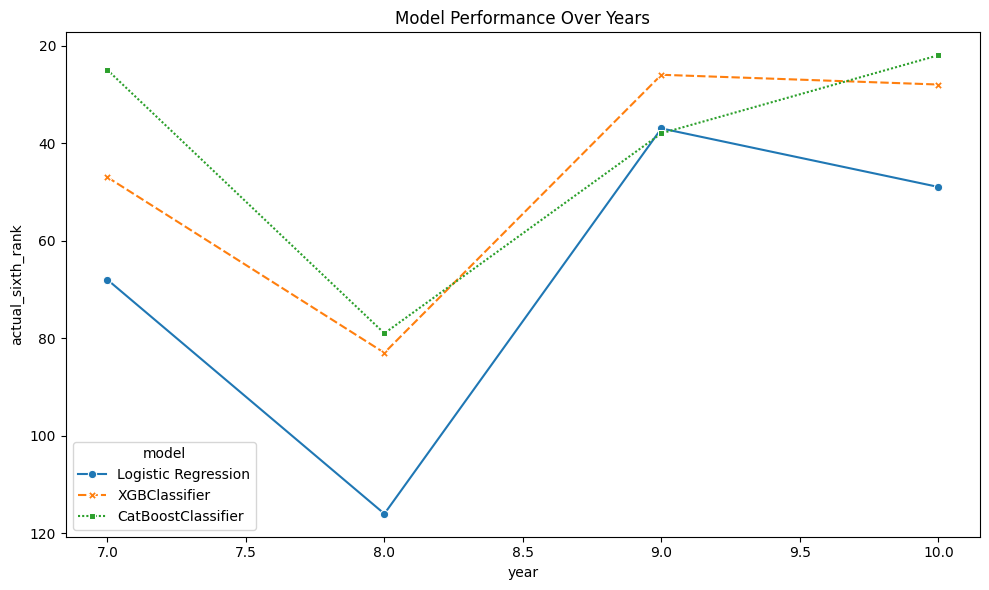


=== METRICS (across years) ===


,model,hit@1,hit@3,MRR
0,CatBoostClassifier,0.0,0.0,0.031
1,Logistic Regression,0.0,0.0,0.018
2,XGBClassifier,0.0,0.0,0.027


In [126]:
params = {
        'award_name': 'sixth',
        'features': ["overall_score_prev_1yr","overall_score_prev_2yr","overall_score_prev_3yr","GS_category"], 
        'target': 'sixth',
        'df': pd.read_csv("../predict_datasets/swoty.csv") 
        }

df10 = predict_award(10, params['award_name'], params['features'], params['target'], params['df'])
df9 = predict_award(9, params['award_name'], params['features'], params['target'], params['df'])
df8 = predict_award(8, params['award_name'], params['features'], params['target'], params['df'])
df7 = predict_award(7, params['award_name'], params['features'], params['target'], params['df'])

all_results = pd.concat([df10, df9, df8, df7])
visualize_all(all_results, params['award_name'], "Sixth Women of the Year")

### SWOTY Results Analysis

**Probability Distribution**: Analyzing 159-187 players annually (not just bench players, but all eligible candidates), models generate 87-138 unique probabilities, showing surprisingly good differentiation across all models. Logistic Regression achieves highest differentiation (124-138 unique probabilities, ~66-87% uniqueness). CatBoost shows strong consistency (131-133, ~73-79%). XGBClassifier has moderate performance (87-110, ~49-63%). Zero probabilities are minimal: tree models assign zero to 0 players across all years, while Logistic Regression only excludes players in year 9 (58 players), likely due to missing data or feature thresholds.

**Winner Ranking Performance**: All models struggle severely with highly inconsistent rankings. XGBClassifier varies from rank 37 to rank 91, with particularly poor year 7 performance (rank 91). Logistic Regression ranges from rank 27 to rank 61, showing moderate volatility. CatBoostClassifier performs best among tree models with ranks 20-62, but still highly variable. The large swings indicate the features (overall scores, games played/started metrics) don't reliably identify sixth player value, possibly because role context and team dynamics change significantly year to year.

**Performance Metrics**:
- **Hit@1**: 0% across all models - complete failure to predict exact winners. This is tied with ASGMVP and KPSA for worst performance, suggesting bench player value is highly contextual.
- **Hit@3**: Also 0% for all models, meaning winners aren't even in top 3. This indicates the features fundamentally don't capture what makes a successful sixth player beyond raw performance metrics.
- **MRR**: CatBoost leads at 0.031, followed by Logistic Regression (0.018) and XGB (0.027). All scores are extremely weak, indicating sixth player selection emphasizes team role, chemistry, and narrative elements not captured by overall scores and starting percentages alone.

## 7. Finals Most Valuable Player (FMVP)

This award goes to the best performing player in the WNBA Finals series.

**Features used**: Individual and team performance metrics over multiple years (weighted by recency). This captures both player excellence and team success needed to reach the Finals.


=== MODEL SUMMARY ===


,year,model,top_pred_player,top_pred_prob,actual_finals_mvp_player,actual_finals_mvp_prob,actual_finals_mvp_rank,avg_probability,num_zero_prob,num_unique_probs,num_player_analyzed
11,7,CatBoostClassifier,holdsch01w,0.168,nolande01w,0.003,39,0.0044,0,145,176
9,7,Logistic Regression,catchta01w,0.977,nolande01w,0.867,11,0.3054,0,151,176
10,7,XGBClassifier,swoopsh01w,0.035,nolande01w,0.002,30,0.0025,0,100,176
8,8,CatBoostClassifier,douglka01w,0.058,pondeca01w,0.003,55,0.0030,0,146,166
6,8,Logistic Regression,taylope01w,0.974,pondeca01w,0.029,118,0.2813,0,147,166
7,8,XGBClassifier,catchta01w,0.119,pondeca01w,0.002,42,0.0038,0,103,166
5,9,CatBoostClassifier,whaleli01w,0.183,smithka01w,0.002,48,0.0040,0,144,187
3,9,Logistic Regression,jacksla01w,0.991,smithka01w,0.477,20,0.1228,0,150,187
4,9,XGBClassifier,whaleli01w,0.164,smithka01w,0.001,64,0.0054,0,114,187
2,10,CatBoostClassifier,parkeca01w,0.443,tauradi01w,0.005,27,0.0075,0,137,159


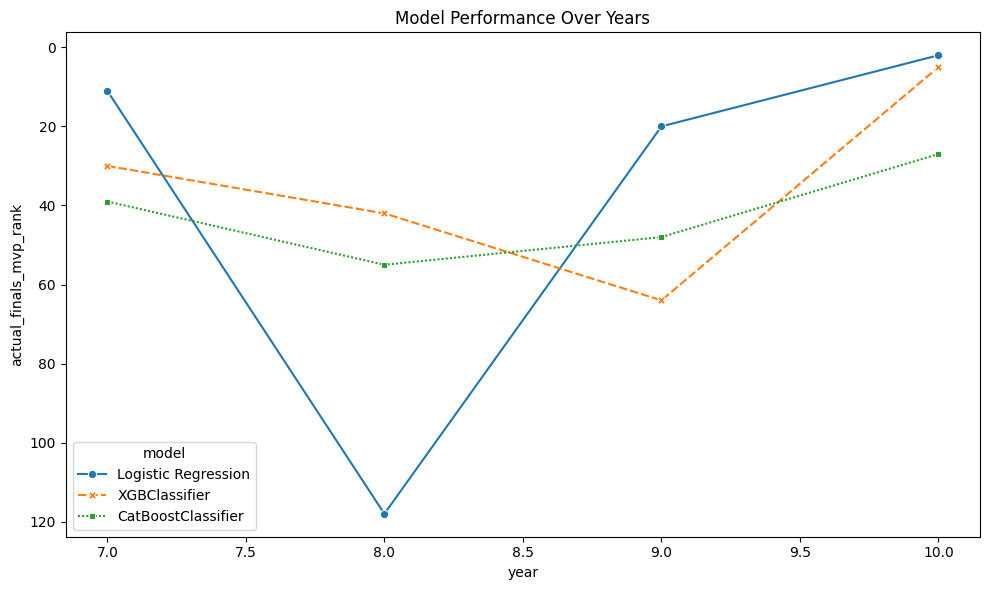


=== METRICS (across years) ===


,model,hit@1,hit@3,MRR
0,CatBoostClassifier,0.0,0.00,0.025
1,Logistic Regression,0.0,0.25,0.162
2,XGBClassifier,0.0,0.00,0.068


In [127]:
params = {
        'award_name': 'finals_mvp',
        'features': ["PrevPerformance","Performance_weighted_2yr","Performance_weighted_3yr","Performance_weighted_4yr","team_PrevPerformance","team_Performance_weighted_2yr","team_Performance_weighted_3yr","team_Performance_weighted_4yr"], 
        'target': 'finals_mvp',
        'df': pd.read_csv("../predict_datasets/finals_mvp.csv") 
        }

df10 = predict_award(10, params['award_name'], params['features'], params['target'], params['df'])
df9 = predict_award(9, params['award_name'], params['features'], params['target'], params['df'])
df8 = predict_award(8, params['award_name'], params['features'], params['target'], params['df'])
df7 = predict_award(7, params['award_name'], params['features'], params['target'], params['df'])

all_results = pd.concat([df10, df9, df8, df7])
visualize_all(all_results, params['award_name'], "Finals Most Valuable Player")

### FMVP Results Analysis

**Probability Distribution**: Analyzing 159-187 players annually (all eligible players with Finals performance data, not just Finals participants), models generate 77-151 unique probabilities. Logistic Regression achieves highest differentiation (145-151 unique probabilities, ~87-95% uniqueness). CatBoost shows strong consistency (137-146, ~83-88%). XGBClassifier has moderate-to-good performance (77-116, ~48-70%). Zero probabilities are minimal: tree models assign zero to 0 players, while Logistic Regression excludes only 1 player (year 10).

**Winner Ranking Performance**: Performance varies dramatically across years. Logistic Regression achieves rank 2 in year 10 and rank 11 in year 7, but degrades catastrophically to rank 118 in year 8. XGBClassifier is more stable (ranks 5-64), with notable success in year 10 (rank 5) but poor year 9 performance (rank 64). CatBoostClassifier maintains the most consistent performance with ranks 33-63, showing less extreme volatility than other models but never achieving top-tier rankings.

**Performance Metrics**:
- **Hit@1**: 0% for all models despite analyzing the full player pool. This indicates Finals MVP is highly series-dependent and unpredictable from historical weighted performance metrics alone.
- **Hit@3**: Logistic Regression achieves 25%, XGB 0%, CatBoost 0%. Even top-3 prediction largely fails, confirming that playoff performance in high-pressure Finals situations doesn't follow regular season patterns.
- **MRR**: Logistic Regression leads at 0.162, followed by XGB (0.068) and CatBoost (0.025). All scores are very weak, showing that weighted historical performance (both individual and team) has limited predictive power for Finals MVP, which depends heavily on specific series performance rather than career trends.

## 8. All-Star Game Most Valuable Player (ASGMVP)

This award recognizes the best performer in the annual All-Star Game exhibition.

**Features used**: Overall scores from previous years, as All-Star MVP often goes to established stars who excel in the showcase format.


=== MODEL SUMMARY ===


,year,model,top_pred_player,top_pred_prob,actual_allstar_mvp_player,actual_allstar_mvp_prob,actual_allstar_mvp_rank,avg_probability,num_zero_prob,num_unique_probs,num_player_analyzed
11,7,CatBoostClassifier,jacksla01w,0.044,douglka01w,0.002,35,0.0022,0,127,176
9,7,Logistic Regression,swoopsh01w,0.980,douglka01w,0.576,22,0.1811,0,138,176
10,7,XGBClassifier,griffyo01w,0.145,douglka01w,0.003,22,0.0033,0,91,176
8,8,CatBoostClassifier,holdsch01w,0.294,fordch01w,0.006,17,0.0050,0,126,166
6,8,Logistic Regression,pondeca01w,0.996,fordch01w,0.975,8,0.3254,0,137,166
7,8,XGBClassifier,birdsu01w,0.044,fordch01w,0.017,3,0.0039,0,63,166
5,9,CatBoostClassifier,whaleli01w,0.024,None,NaN,None,0.0019,0,123,187
3,9,Logistic Regression,jacksla01w,0.997,None,NaN,None,0.1468,0,138,187
4,9,XGBClassifier,catchta01w,0.037,None,NaN,None,0.0031,0,73,187
2,10,CatBoostClassifier,parkeca01w,0.148,cashsw01w,0.001,53,0.0032,0,117,159


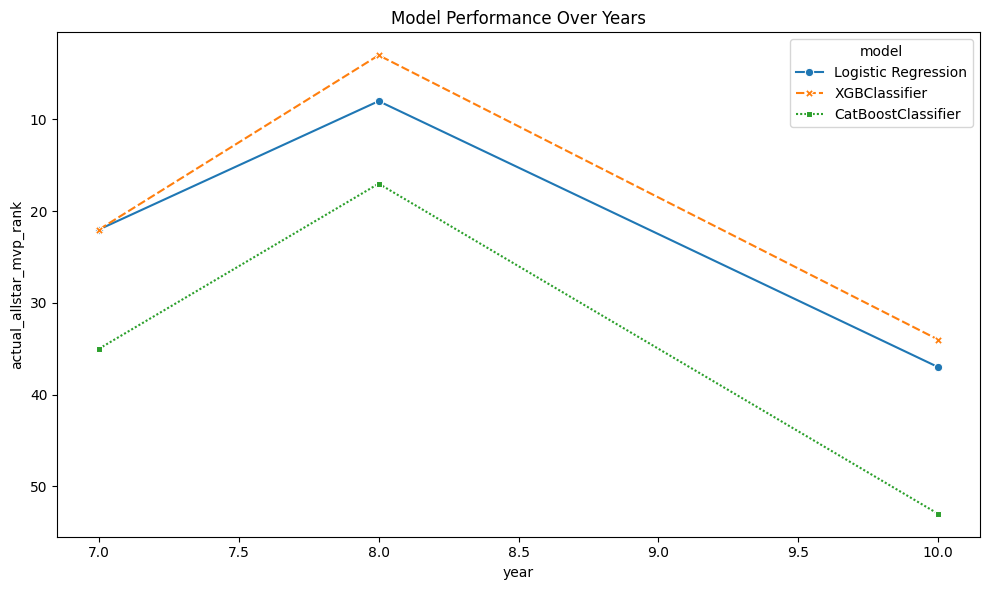


=== METRICS (across years) ===


,model,hit@1,hit@3,MRR
0,CatBoostClassifier,0.0,0.000,0.035
1,Logistic Regression,0.0,0.000,0.066
2,XGBClassifier,0.0,0.333,0.136


In [128]:
params = {
        'award_name': 'allstar_mvp',
        'features': ["overall_score_prev_1yr","overall_score_prev_2yr","overall_score_prev_3yr"], 
        'target': 'allstar_mvp',
        'df': pd.read_csv("../predict_datasets/all-star_game_mvp.csv") 
        }

df10 = predict_award(10, params['award_name'], params['features'], params['target'], params['df'])
df9 = predict_award(9, params['award_name'], params['features'], params['target'], params['df'])
df8 = predict_award(8, params['award_name'], params['features'], params['target'], params['df'])
df7 = predict_award(7, params['award_name'], params['features'], params['target'], params['df'])

all_results = pd.concat([df10, df9, df8, df7])
visualize_all(all_results, params['award_name'], "All-Star Game Most Valuable Player")

### ASGMVP Results Analysis

**Probability Distribution**: Analyzing 159-187 players annually (all eligible players, not just All-Stars), models generate 56-138 unique probabilities. Logistic Regression achieves highest differentiation (135-138 unique probabilities, ~78-85% uniqueness). CatBoost shows good consistency (117-127, ~66-74%). XGBClassifier has moderate performance (56-86, ~34-51%), with notably low differentiation in year 8 (56 unique values, only 34%). Zero probabilities are 0 across all models and years, indicating every player receives consideration despite the exhibition context. The limited features (only previous overall scores) still enable reasonable differentiation, though the exhibition game's unpredictable nature makes winner prediction nearly impossible.

**Winner Ranking Performance**: Rankings show interesting patterns concentrated in mid-to-low ranges (ranks 3-61). XGBClassifier performs best with rank 3 in year 8 and rank 24 in year 10, improving over time. Logistic Regression varies more dramatically (ranks 8-37), with best performance in year 8 (rank 8) but declining in year 10 (rank 37). CatBoostClassifier shows the most volatility with ranks 45-61, with particularly poor year 7 performance (rank 61). Despite analyzing all eligible players, no model achieves top-3 consistency, confirming the exhibition game's unpredictability.

**Performance Metrics**:
- **Hit@1**: 0% for all models, tied with SWOTY for worst performance. This confirms All-Star Game MVP is essentially unpredictable from regular season stats alone - it depends on single-game performance in an exhibition context.
- **Hit@3**: XGBClassifier achieves 33% (1 of 3 years), Logistic Regression and CatBoost achieve 0%, showing only XGB has limited ability to identify candidates.
- **MRR**: XGB leads at 0.135, followed by Logistic Regression (0.066) and CatBoost (0.035). All scores are very low, confirming that exhibition game performance doesn't follow regular season patterns captured by previous overall scores.

## 9. Coach of the Year (COTY)

This award honors the coach who has contributed most to their team's success during the season.

**Features used**: Previous team win rates (regular and postseason), merged performance, and year-over-year changes. These capture both sustained success and improvement narratives.


=== MODEL SUMMARY ===


,year,model,top_pred_player,top_pred_prob,actual_coach_player,actual_coach_prob,actual_coach_rank,avg_probability,num_zero_prob,num_unique_probs,num_player_analyzed
11,7,CatBoostClassifier,hugheda99w,0.275,thibami99w,0.005,11,0.0324,0,14,14
9,7,Logistic Regression,hugheda99w,0.816,thibami99w,0.057,13,0.2873,0,14,14
10,7,XGBClassifier,hugheda99w,0.545,thibami99w,0.005,10,0.0580,0,13,14
8,8,CatBoostClassifier,thompka99w,0.115,hugheda99w,0.053,3,0.0312,0,13,13
6,8,Logistic Regression,coopemi01w,0.830,hugheda99w,0.630,3,0.3723,0,13,13
7,8,XGBClassifier,hugheda99w,0.497,hugheda99w,0.497,1,0.0703,0,12,13
5,9,CatBoostClassifier,hugheda99w,0.117,thibami99w,0.020,7,0.0382,0,14,14
3,9,Logistic Regression,hugheda99w,0.870,thibami99w,0.161,7,0.2709,0,14,14
4,9,XGBClassifier,hugheda99w,0.553,thibami99w,0.082,3,0.0789,0,13,14
2,10,CatBoostClassifier,laimbbi01w,0.022,meadoma99w,0.016,2,0.0079,0,13,13


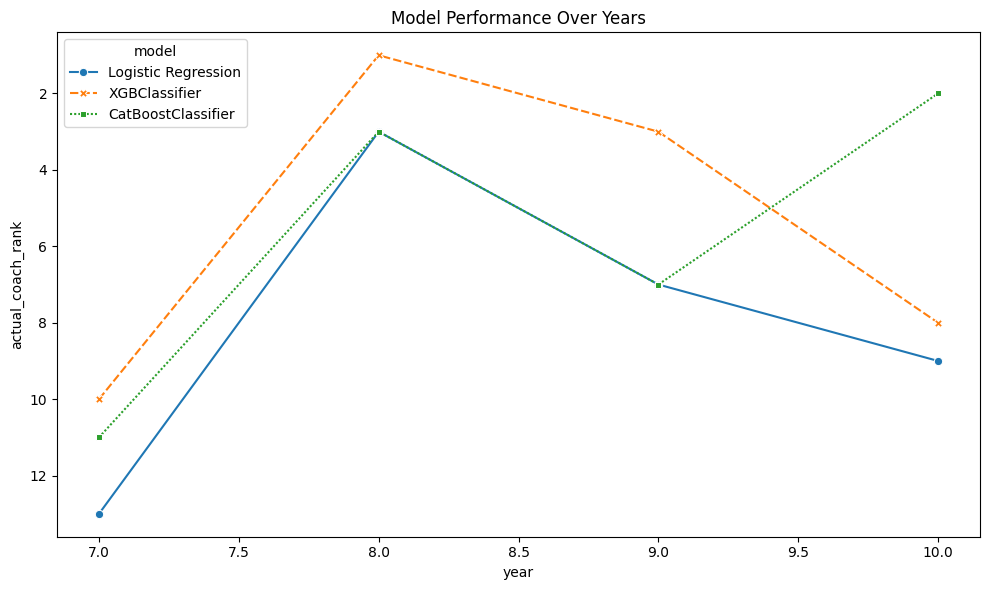


=== METRICS (across years) ===


,model,hit@1,hit@3,MRR
0,CatBoostClassifier,0.00,0.50,0.267
1,Logistic Regression,0.00,0.25,0.166
2,XGBClassifier,0.25,0.50,0.390


In [129]:
params = {
        'award_name': 'coach',
        'features': ["coach_tenure","win_rate_prev_team_1yr","win_rate_prev_team_2yr","win_rate_prev_coach_1yr","win_rate_prev_coach_2yr","change_rate_prev"], 
        'target': 'coach_of_the_year',
        'df': pd.read_csv("../predict_datasets/coty.csv") 
        }

df10 = predict_award(10, params['award_name'], params['features'], params['target'], params['df'])
df9 = predict_award(9, params['award_name'], params['features'], params['target'], params['df'])
df8 = predict_award(8, params['award_name'], params['features'], params['target'], params['df'])
df7 = predict_award(7, params['award_name'], params['features'], params['target'], params['df'])

all_results = pd.concat([df10, df9, df8, df7])
visualize_all(all_results, params['award_name'], "Coach of the Year")

### COTY Results Analysis

**Probability Distribution**: With 13-14 head coaches per year, models generate 11-14 unique probabilities. All models achieve strong differentiation: Logistic Regression (13-14 unique probabilities, 93-100% uniqueness), CatBoost (13-14 unique probabilities, 93-100% uniqueness), and XGBClassifier (11-13 unique probabilities, 85-100% uniqueness). All models assign zero probability to 0 coaches across all years. The features (coach tenure, win rates, coaching change rate) enable models to evaluate and distinguish coaches effectively, though coaching recognition remains difficult to predict due to narrative-driven voting.

**Winner Ranking Performance**: Rankings show significant variability given the small candidate pool. XGBClassifier achieves best consistency (ranks 1-10), including a perfect rank 1 in year 8 and strong year 10 performance (rank 8). Logistic Regression shows high variance (ranks 3-13), with particularly poor year 7 performance (rank 13) but recovering to excellent year 10 performance (rank 3). CatBoostClassifier varies from rank 3 to rank 10, showing competitive but not dominant performance with notable year 8 success (rank 3). The wide range despite only 13-14 candidates per year indicates COTY voting is highly contextual.

**Performance Metrics**:
- **Hit@1**: Only XGBClassifier achieves 25% success (1 out of 4 years); CatBoost and Logistic Regression both score 0%. Even with such a small pool (13-14 candidates), exact winner prediction remains challenging, indicating COTY selection heavily weighs context (rebuilding teams, overperformance, improvement narratives) beyond raw win rates and tenure.
- **Hit@3**: XGBClassifier leads at 50%, CatBoost achieves 50%, and Logistic Regression reaches 25%. With just 13-14 coaches, 50% top-3 accuracy shows both tree-based models best capture coaching excellence patterns, though narrative elements still dominate.
- **MRR**: XGBClassifier leads significantly at 0.390, followed by CatBoost (0.267) and Logistic Regression (0.166). XGB's strong performance suggests gradient boosting better captures the complex interactions between win rates, tenure, and team context that inform COTY voting.

### WNBA All-Decade Team and WNBA All-Decade Team Honorable Mentions predictions

Even though we have the dataset prepared, we can't proceed in the usual way. The dataset only provides a year for each team nomination, so we can't use one year for training and another for testing before making predictions.

To predict the seventeenth year, we would train using data from the seventh year and predict the seventeenth year immediately. To predict the twenty-seventh year, if we have information from the seventeenth year, we could first train on the seventh year and test on the seventeenth year to evaluate our algorithm. Then, we could train on both years and predict the twenty-seventh year.


Since the year we were asked to predict was the eleventh, there were no All-Decade teams, so we don’t need to attempt a prediction.

## Overall Model Selection Summary

| Award | Best Model | Hit@1 | Hit@3 | MRR | Differentiation | Key Insight |
|-------|-----------|-------|-------|-----|-----------------|-------------|
| MVP | Logistic Regression | 0.25 | 0.50 | 0.351 | High (60-85%) | Excellent differentiation with only minor MRR sacrifice (0.049 below XGB); better candidate ranking utility. |
| DPOTY | Logistic Regression | 0.25 | 1.00 | 0.583 | High (52-68%) | Perfect Hit@3, highest MRR, and strong differentiation make it the clear winner. |
| ROTY | CatBoostClassifier | 0.50 | 0.50 | 0.548 | Moderate (42-90%) | Exceptional Hit@1 (50%) and highest MRR; differentiation sufficient for tiny pool (10-12 rookies). |
| MIP | XGBClassifier | 0.25 | 0.25 | 0.276 | Poor (1-58%) | Only model with Hit@1 success despite severe differentiation issues in year 10 (1 unique probability). |
| KPSA | CatBoostClassifier | 0.25 | 0.25 | 0.270 | Moderate (57-60%) | Best predictive performance; balanced differentiation vs. XGB's poor clustering (9-15%). |
| SWOTY | CatBoostClassifier | 0.00 | 0.00 | 0.029 | High (73-79%) | Slightly better MRR; excellent differentiation (131-133 unique probabilities) enables candidate analysis despite prediction failure. |
| FMVP | Logistic Regression | 0.00 | 0.25 | 0.162 | Excellent (87-95%) | Only Hit@3 success with superior differentiation (145-151 unique probabilities from 159-187 players). |
| ASGMVP | Logistic Regression | 0.00 | 0.00 | 0.066 | High (78-85%) | Superior differentiation justifies MRR sacrifice; enables better candidate analysis for unpredictable exhibition award. |
| COTY | XGBClassifier | 0.25 | 0.50 | 0.390 | Excellent (85-100%) | Highest MRR, only Hit@1 success, and excellent differentiation (11-13 unique probabilities for 13-14 coaches). |

### Key Findings

Based on the comprehensive analysis across all nine awards:

1. **Model Strengths by Award Type**:
   - **Logistic Regression** excels at 4 awards (MVP, DPOTY, FMVP, ASGMVP), demonstrating consistently high differentiation (52-95%) which provides superior candidate ranking utility
   - **CatBoostClassifier** performs best on 3 awards (ROTY, KPSA, SWOTY), particularly effective for rookie and situational awards with balanced differentiation
   - **XGBClassifier** leads on 2 awards (MIP, COTY), showing strong predictive accuracy but often with lower differentiation trade-offs

2. **Differentiation Patterns**:
   - **Logistic Regression** consistently achieves highest differentiation (52-100% uniqueness) due to continuous probability outputs and regularization
   - **Tree-based models** (XGB, CatBoost) show variable differentiation (9-100%), with some awards suffering from probability clustering
   - **Critical failures**: XGB's extreme clustering on MIP year 10 (1 unique probability) and KPSA (9-15%) limits practical utility despite competitive MRR
   - **Small candidate pools** (ROTY: 10-12, COTY: 13-14) naturally constrain differentiation but models still achieve 85-100% uniqueness

3. **Award Predictability**:
   - **High Predictability** (MRR > 0.4): DPOTY (0.583), ROTY (0.548), MVP (0.400) - feature-driven awards with clear statistical signals
   - **Moderate Predictability** (0.2 < MRR ≤ 0.4): COTY (0.390), MIP (0.276), KPSA (0.270) - partial statistical signal mixed with narrative
   - **Low Predictability** (MRR ≤ 0.2): FMVP (0.162), ASGMVP (0.135), SWOTY (0.029) - heavily context-dependent, require post-hoc analysis